ЕГОРОВ Д.А.
____
18-АС
____
2 ВАРИАНТ

ПОДКЛЮЧЕНИЕ ВСЕХ НЕОБХОДИМЫХ ЗАВИСИМОСТЕЙ

In [2]:
!pip install -U keras-tuner
!pip install -U pygal

import pandas as pd
import numpy as np
import random
import pygal
from keras.datasets import boston_housing
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten
from keras.optimizers import SGD
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from kerastuner.engine import hyperparameters
from keras.layers import Dropout
from keras import backend as K
from keras.regularizers import L1, L2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
from keras import utils
from sklearn.preprocessing import MinMaxScaler


     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=4b6caa607534fdbc3965e9d0055a2e252a4b5a89393ade10544e275c1aff9921
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=2290a58b7d06fa1a3cdc3efcfe4e0dcf0d66c099a11c932ad57c49a90fd1642a
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
     |████████████████████████████████| 133kB 3.0MB/s 


ЧТЕНИЕ И ВЫВОД ИСХОДНЫХ ДАННЫХ


In [3]:
TRAIN_FILE_PATH = '/content/drive/My Drive/train.csv'

# загружаем данные
x = pd.read_csv(TRAIN_FILE_PATH) 

x

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


ПОЛУЧЕНИЕ ВЕРНЫХ ОТВЕТОВ

In [4]:
y = x.get('y')

УДАЛЕНИЕ ЛИШНИХ СТОЛБЦОВ

In [5]:
x.drop('y', axis='columns', inplace=True)
x.drop('ID', axis='columns', inplace=True)
x.head()

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,...,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,az,t,n,f,d,x,l,e,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,az,v,n,f,d,h,d,n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


НАХОЖДЕНИЕ ВСЕХ СТОЛБЦОВ, В КОТОРЫХ НЕНУЛЕВОЕ ЗНАЧЕНИЕ ИМЕЕТСЯ ТОЛЬКО В ПЕРВОЙ СТРОКЕ

In [6]:
suspicious_data = []
for col in x:
    if len(x[col].unique()) == 1:
        suspicious_data.append(col)
x[suspicious_data].describe()

,X11,X93,X107,X233,X235,X268,X289,X290,X293,X297,X330,X347
count,4209.0,4209.0,4209.0,4209.0,4209.0,4209.0,4209.0,4209.0,4209.0,4209.0,4209.0,4209.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


УДАЛЕНИЕ ВСЕХ ТАКИХ СТОЛБЦОВ

In [7]:
x.drop(suspicious_data, 1, inplace = True)

ПОЛУЧЕНИЕ СПИСКА ПРИЗНАКОВ, ЗАШИФРОВАННЫХ БУКВЕННО

In [8]:
cat_vars = [var for var in x.columns if x[var].dtypes == 'O']
print('Number of categorical variables: ', len(cat_vars))

x[cat_vars]

Number of categorical variables:  8


,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n
...,...,...,...,...,...,...,...,...
4204,ak,s,as,c,d,aa,d,q
4205,j,o,t,d,d,aa,h,h
4206,ak,v,r,a,d,aa,g,e
4207,al,r,e,f,d,aa,l,u


КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ ШИФРУЮТСЯ ЧЕРЕЗ LABEL ENCODER В ЧИСЛА

In [9]:
df = pd.DataFrame(x[cat_vars])
x[cat_vars] = df.apply(preprocessing.LabelEncoder().fit_transform)

x[cat_vars]

,X0,X1,X2,X3,X4,X5,X6,X8
0,32,23,17,0,3,24,9,14
1,32,21,19,4,3,28,11,14
2,20,24,34,2,3,27,9,23
3,20,21,34,5,3,27,11,4
4,20,23,34,5,3,12,3,13
...,...,...,...,...,...,...,...,...
4204,8,20,16,2,3,0,3,16
4205,31,16,40,3,3,0,7,7
4206,8,23,38,0,3,0,6,4
4207,9,19,25,5,3,0,11,20


НОРМАЛИЗАЦИЯ ДАННЫХ

In [10]:
scaler = MinMaxScaler()
x[cat_vars] = scaler.fit_transform(x[cat_vars])

x

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,...,X344,X345,X346,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0.695652,0.884615,0.395349,0.000000,1.0,0.857143,0.818182,0.583333,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.695652,0.807692,0.441860,0.666667,1.0,1.000000,1.000000,0.583333,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.434783,0.923077,0.790698,0.333333,1.0,0.964286,0.818182,0.958333,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.434783,0.807692,0.790698,0.833333,1.0,0.964286,1.000000,0.166667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0.434783,0.884615,0.790698,0.833333,1.0,0.428571,0.272727,0.541667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,0.173913,0.769231,0.372093,0.333333,1.0,0.000000,0.272727,0.666667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4205,0.673913,0.615385,0.930233,0.500000,1.0,0.000000,0.636364,0.291667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4206,0.173913,0.884615,0.883721,0.000000,1.0,0.000000,0.545455,0.166667,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4207,0.195652,0.730769,0.581395,0.833333,1.0,0.000000,1.000000,0.833333,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


ПРОВЕРКА НА НАЛИЧИЕ NaN

In [11]:
def check_nans(data):
  nan_cols = []
  for col_name, col_info in data.items():
    for line_number, line_info in col_info.items():
      if math.isnan(line_info):
        print(f"{col_name } is NaNs")
        nan_cols.append(col_name)
        break
  if nan_cols == []:
    print("[INFO] THERE IS NO NaNS IN DATA!")
  return nan_cols

nan_cols = check_nans(x)

[INFO] THERE IS NO NaNS IN DATA!


ДЕЛЕНИЕ ДАННЫХ НА ТРЕНИРОВОЧНЫЕ И ПРОВЕРОЧНЫЕ

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size = 0.2)

СОЗДАНИЕ И ОБУЧЕНИЕ МОДЕЛИ ВРУЧНУЮ

In [13]:
model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))


model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()
history = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2)
history = history.history


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               186880    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 351,233
Trainable params: 351,233
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
22/22 [==============================] - 1s 23ms/step - loss: 5051.3525 - mae: 63.0369 - val_loss: 537.4

СОЗДАНИЕ ГРАФИКОВ

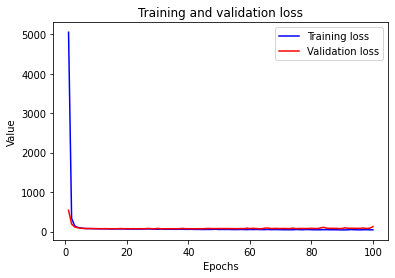

In [14]:
def draw_graph(history):
    loss_values = history["loss"]
    validation_loss_values = history["val_loss"]

    epochs = range(1, len(history['loss']) + 1)

    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, validation_loss_values, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

draw_graph(history)

ВЫЧИСЛЕНИЕ ОШИБКИ НА ТЕСТОВЫХ ДАННЫХ


In [15]:
print("[INFO] RUNNING ON TEST DATA: \n")
mse, mae = model.evaluate(x_test, y_test, verbose=0, batch_size=128)
print(f"[INFO] Mean squared error is {mse}")
print(f"[INFO] Mean absolute error is {mae}")

[INFO] RUNNING ON TEST DATA: 

[INFO] Mean squared error is 164.73789978027344
[INFO] Mean absolute error is 9.954938888549805


ФУНКЦИЯ СОЗДАНИЯ МОДЕЛИ


In [16]:
def build_model(hp):
  hidden_layers = hp.Choice('hidden_layers', values=[1,2,3])
  activation_choice = hp.Choice('activation', values=['relu', 'selu', 'elu'])
  model = Sequential()
  model.add(Dense(units=hp.Int('units',min_value=256,max_value=512,step=32),activation=activation_choice, input_shape=(x_train.shape[1], ), kernel_regularizer=L2(0.001)))
  model.add(Dropout(0.3))
  for i in range(hidden_layers):
    model.add(Dense(units=hp.Int(f'layer_{i}_units_',min_value=32//(i+1), max_value=128//(i+1),step=64//(i+1)),activation=activation_choice, kernel_regularizer=L2(0.001)))
  model.add(Dense(1))  
  model.compile(optimizer='rmsprop', loss="mse", metrics=["mae"])
  return model

1)      ПОИСК ЛУЧШЕЙ МОДЕЛИ С ПОМОЩЬЮ RANDOM_SEARCH

In [ ]:
def find_best_NN(x_train, y_train):
  tuner = RandomSearch(build_model, objective="loss", max_trials=10, executions_per_trial=1)
  print("\n\n\n")
  print('[INFO] start searching')
  tuner.search(x_train, y_train, batch_size=100, epochs=10, validation_split=0.2)
  print("\n\n\nRESULTS SUMMARY")
  tuner.results_summary()
  print("\n\n\n")
  print("\n\n\nHERE IS THE BEST MODEL\n\n\n")
  best_params = tuner.get_best_hyperparameters()[0]
  best_model = tuner.hypermodel.build(best_params)
  best_model.summary()
  return best_model

best_model = find_best_NN(x_train, y_train)

2)  ПОИСК ЛУЧШЕЙ МОДЕЛИ С ПОМОЩЬЮ HYPER_BAND

In [17]:

def find_best_NN(x_train_main, y_train_main):
  tuner = Hyperband(build_model, objective="loss", max_epochs=10, hyperband_iterations=3)
  print("\n\n\n")
  print('[INFO] start searching')
  tuner.search(x_train, y_train, batch_size=128, epochs=10, validation_split=0.2)
  print("\n\n\nRESULTS SUMMARY")
  tuner.results_summary()
  print("\n\n\n")
  print("\n\n\nHERE IS THE BEST MODEL\n\n\n")
  best_params = tuner.get_best_hyperparameters()[0]
  best_model = tuner.hypermodel.build(best_params)
  best_model.summary()
  return best_model
  

best_model = find_best_NN(x_train, y_train)






[INFO] start searching
Epoch 1/2
22/22 [==============================] - 0s 22ms/step - loss: 3299.6121 - mae: 47.2656 - val_loss: 195.9599 - val_mae: 10.8546
Epoch 2/2
22/22 [==============================] - 0s 11ms/step - loss: 175.5004 - mae: 10.2486 - val_loss: 169.0488 - val_mae: 10.3885


Epoch 1/2
22/22 [==============================] - 0s 22ms/step - loss: 2747.1477 - mae: 41.7696 - val_loss: 180.6317 - val_mae: 10.4760
Epoch 2/2
22/22 [==============================] - 0s 11ms/step - loss: 164.3423 - mae: 9.8062 - val_loss: 145.7786 - val_mae: 8.7495


Epoch 1/2
22/22 [==============================] - 0s 18ms/step - loss: 4033.3850 - mae: 52.8869 - val_loss: 256.8734 - val_mae: 12.6472
Epoch 2/2
22/22 [==============================] - 0s 9ms/step - loss: 200.7452 - mae: 10.8596 - val_loss: 161.5264 - val_mae: 9.9089


Epoch 1/2
22/22 [==============================] - 0s 18ms/step - loss: 3047.8225 - mae: 45.8153 - val_loss: 190.1653 - val_mae: 10.6728
Epoch 2/2
22/22 [==============================] - 0s 11ms/step - loss: 172.6933 - mae: 10.1469 - val_loss: 139.7907 - val_mae: 8.7325


Epoch 1/2
22/22 [==============================] - 0s 19ms/step - loss: 3968.7427 - mae: 52.5983 - val_loss: 227.2977 - val_mae: 11.6111
Epoch 2/2
22/22 [==============================] - 0s 9ms/step - loss: 206.5173 - mae: 11.0309 - val_loss: 141.7751 - val_mae: 8.4892


Epoch 1/2
22/22 [==============================] - 0s 21ms/step - loss: 6367.7222 - mae: 77.0418 - val_loss: 1259.1217 - val_mae: 33.0772
Epoch 2/2
22/22 [==============================] - 0s 10ms/step - loss: 376.9162 - mae: 14.8096 - val_loss: 173.0906 - val_mae: 10.2950


Epoch 1/2
22/22 [==============================] - 0s 18ms/step - loss: 3953.0884 - mae: 55.7759 - val_loss: 301.0122 - val_mae: 13.3270
Epoch 2/2
22/22 [==============================] - 0s 10ms/step - loss: 205.5467 - mae: 11.0989 - val_loss: 155.0293 - val_mae: 9.3829


Epoch 1/2
22/22 [==============================] - 1s 24ms/step - loss: 2352.9248 - mae: 33.7032 - val_loss: 440.8776 - val_mae: 18.6398
Epoch 2/2
22/22 [==============================] - 0s 15ms/step - loss: 184.5455 - mae: 10.4351 - val_loss: 258.0266 - val_mae: 14.3192


Epoch 1/2
22/22 [==============================] - 0s 21ms/step - loss: 2871.6599 - mae: 44.4321 - val_loss: 181.9089 - val_mae: 10.1832
Epoch 2/2
22/22 [==============================] - 0s 11ms/step - loss: 164.2967 - mae: 9.8201 - val_loss: 133.4580 - val_mae: 8.3171


Epoch 1/2
22/22 [==============================] - 0s 21ms/step - loss: 2924.9849 - mae: 42.8818 - val_loss: 174.3640 - val_mae: 10.0764
Epoch 2/2
22/22 [==============================] - 0s 11ms/step - loss: 151.8976 - mae: 9.4360 - val_loss: 118.9970 - val_mae: 7.9323


Epoch 1/2
22/22 [==============================] - 0s 20ms/step - loss: 3722.4897 - mae: 54.6979 - val_loss: 379.0097 - val_mae: 15.3905
Epoch 2/2
22/22 [==============================] - 0s 10ms/step - loss: 217.4499 - mae: 11.3906 - val_loss: 158.0977 - val_mae: 9.7894


Epoch 1/2
22/22 [==============================] - 0s 21ms/step - loss: 2136.8760 - mae: 33.6964 - val_loss: 159.5348 - val_mae: 9.6612
Epoch 2/2
22/22 [==============================] - 0s 12ms/step - loss: 141.8175 - mae: 9.0542 - val_loss: 109.5393 - val_mae: 7.6075


Epoch 3/4
22/22 [==============================] - 1s 26ms/step - loss: 2408.8450 - mae: 37.5576 - val_loss: 166.0536 - val_mae: 9.9911
Epoch 4/4
22/22 [==============================] - 0s 12ms/step - loss: 142.9939 - mae: 9.1238 - val_loss: 119.1806 - val_mae: 7.6766


Epoch 3/4
22/22 [==============================] - 0s 18ms/step - loss: 1985.7751 - mae: 31.8058 - val_loss: 140.4502 - val_mae: 9.0544
Epoch 4/4
22/22 [==============================] - 0s 10ms/step - loss: 131.1207 - mae: 8.5469 - val_loss: 151.5202 - val_mae: 8.7078


Epoch 3/4
22/22 [==============================] - 0s 22ms/step - loss: 2595.6213 - mae: 40.6394 - val_loss: 192.6571 - val_mae: 10.4761
Epoch 4/4
22/22 [==============================] - 0s 12ms/step - loss: 162.5109 - mae: 9.6669 - val_loss: 133.9081 - val_mae: 8.3027


Epoch 3/4
22/22 [==============================] - 0s 22ms/step - loss: 2783.2935 - mae: 41.7455 - val_loss: 175.2119 - val_mae: 10.2602
Epoch 4/4
22/22 [==============================] - 0s 10ms/step - loss: 164.1812 - mae: 9.8193 - val_loss: 127.7574 - val_mae: 8.5700


Epoch 5/10
22/22 [==============================] - 1s 27ms/step - loss: 2757.4731 - mae: 41.7678 - val_loss: 162.1052 - val_mae: 9.8459
Epoch 6/10
22/22 [==============================] - 0s 14ms/step - loss: 146.8635 - mae: 9.2835 - val_loss: 119.8412 - val_mae: 7.8392
Epoch 7/10
22/22 [==============================] - 0s 14ms/step - loss: 122.2093 - mae: 8.2003 - val_loss: 117.7925 - val_mae: 7.2444
Epoch 8/10
22/22 [==============================] - 0s 13ms/step - loss: 113.0342 - mae: 7.8212 - val_loss: 83.1769 - val_mae: 6.3805
Epoch 9/10
22/22 [==============================] - 0s 13ms/step - loss: 102.5680 - mae: 7.3683 - val_loss: 124.0946 - val_mae: 7.5772
Epoch 10/10
22/22 [==============================] - 0s 10ms/step - loss: 91.5401 - mae: 6.8876 - val_loss: 77.1775 - val_mae: 6.3839


Epoch 5/10
22/22 [==============================] - 0s 23ms/step - loss: 1911.1012 - mae: 31.8001 - val_loss: 156.3812 - val_mae: 9.3141
Epoch 6/10
22/22 [==============================] - 0s 13ms/step - loss: 135.4466 - mae: 8.7915 - val_loss: 257.1991 - val_mae: 12.7604
Epoch 7/10
22/22 [==============================] - 0s 13ms/step - loss: 120.8875 - mae: 8.1238 - val_loss: 87.3753 - val_mae: 6.3217
Epoch 8/10
22/22 [==============================] - 0s 13ms/step - loss: 99.6696 - mae: 7.2881 - val_loss: 164.8038 - val_mae: 11.3941
Epoch 9/10
22/22 [==============================] - 0s 14ms/step - loss: 102.2764 - mae: 7.3655 - val_loss: 82.3986 - val_mae: 6.8717
Epoch 10/10
22/22 [==============================] - 0s 14ms/step - loss: 101.4027 - mae: 7.2777 - val_loss: 101.7404 - val_mae: 8.3687


Epoch 1/4
22/22 [==============================] - 1s 24ms/step - loss: 5026.0903 - mae: 60.5280 - val_loss: 266.6599 - val_mae: 12.8872
Epoch 2/4
22/22 [==============================] - 0s 13ms/step - loss: 199.5294 - mae: 10.7269 - val_loss: 287.5602 - val_mae: 13.3590
Epoch 3/4
22/22 [==============================] - 0s 15ms/step - loss: 153.5413 - mae: 9.3022 - val_loss: 116.6936 - val_mae: 7.2737
Epoch 4/4
22/22 [==============================] - 0s 13ms/step - loss: 127.6514 - mae: 8.5762 - val_loss: 260.6302 - val_mae: 14.5892


Epoch 1/4
22/22 [==============================] - 1s 26ms/step - loss: 3105.8772 - mae: 43.1650 - val_loss: 170.8912 - val_mae: 9.7724
Epoch 2/4
22/22 [==============================] - 0s 14ms/step - loss: 144.4846 - mae: 9.1103 - val_loss: 174.3919 - val_mae: 9.5639
Epoch 3/4
22/22 [==============================] - 0s 14ms/step - loss: 130.9164 - mae: 8.5271 - val_loss: 142.3663 - val_mae: 10.1324
Epoch 4/4
22/22 [==============================] - 0s 13ms/step - loss: 118.5875 - mae: 8.2063 - val_loss: 332.8295 - val_mae: 15.8847


Epoch 1/4
22/22 [==============================] - 1s 26ms/step - loss: 4256.8823 - mae: 54.0894 - val_loss: 219.8956 - val_mae: 11.3370
Epoch 2/4
22/22 [==============================] - 0s 14ms/step - loss: 195.7570 - mae: 10.7636 - val_loss: 158.8143 - val_mae: 8.9426
Epoch 3/4
22/22 [==============================] - 0s 13ms/step - loss: 148.0733 - mae: 9.1868 - val_loss: 171.4576 - val_mae: 11.1166
Epoch 4/4
22/22 [==============================] - 0s 14ms/step - loss: 128.1842 - mae: 8.5286 - val_loss: 218.9517 - val_mae: 13.2293


Epoch 1/4
22/22 [==============================] - 1s 23ms/step - loss: 2797.0530 - mae: 43.1779 - val_loss: 182.7628 - val_mae: 10.2740
Epoch 2/4
22/22 [==============================] - 0s 11ms/step - loss: 166.4310 - mae: 9.8394 - val_loss: 137.7153 - val_mae: 8.4449
Epoch 3/4
22/22 [==============================] - 0s 11ms/step - loss: 119.2554 - mae: 8.1298 - val_loss: 105.7907 - val_mae: 6.9927
Epoch 4/4
22/22 [==============================] - 0s 11ms/step - loss: 104.4654 - mae: 7.4952 - val_loss: 99.9023 - val_mae: 6.4966


Epoch 1/4
22/22 [==============================] - 1s 25ms/step - loss: 3943.1147 - mae: 53.0296 - val_loss: 190.3968 - val_mae: 10.6572
Epoch 2/4
22/22 [==============================] - 0s 12ms/step - loss: 176.6275 - mae: 10.2763 - val_loss: 183.5259 - val_mae: 10.9900
Epoch 3/4
22/22 [==============================] - 0s 11ms/step - loss: 142.8176 - mae: 9.0259 - val_loss: 462.0297 - val_mae: 19.8788
Epoch 4/4
22/22 [==============================] - 0s 13ms/step - loss: 124.7816 - mae: 8.2260 - val_loss: 90.8222 - val_mae: 6.9764


Epoch 1/4
22/22 [==============================] - 1s 29ms/step - loss: 3071.3701 - mae: 43.6879 - val_loss: 183.3353 - val_mae: 10.3691
Epoch 2/4
22/22 [==============================] - 0s 12ms/step - loss: 161.5407 - mae: 9.6219 - val_loss: 123.0064 - val_mae: 7.9174
Epoch 3/4
22/22 [==============================] - 0s 13ms/step - loss: 128.1645 - mae: 8.4223 - val_loss: 99.3671 - val_mae: 7.3993
Epoch 4/4
22/22 [==============================] - 0s 11ms/step - loss: 113.9086 - mae: 7.9062 - val_loss: 90.2666 - val_mae: 7.1345


Epoch 5/10
22/22 [==============================] - 0s 22ms/step - loss: 2513.2151 - mae: 39.1121 - val_loss: 179.1403 - val_mae: 10.1126
Epoch 6/10
22/22 [==============================] - 0s 11ms/step - loss: 157.6654 - mae: 9.6748 - val_loss: 122.0601 - val_mae: 8.0987
Epoch 7/10
22/22 [==============================] - 0s 12ms/step - loss: 128.5059 - mae: 8.3831 - val_loss: 106.7444 - val_mae: 8.1002
Epoch 8/10
22/22 [==============================] - 0s 11ms/step - loss: 102.4433 - mae: 7.4480 - val_loss: 226.3357 - val_mae: 13.6183
Epoch 9/10
22/22 [==============================] - 0s 12ms/step - loss: 94.5306 - mae: 7.0089 - val_loss: 141.2098 - val_mae: 8.4546
Epoch 10/10
22/22 [==============================] - 0s 12ms/step - loss: 93.4786 - mae: 7.0143 - val_loss: 108.0499 - val_mae: 6.8024


Epoch 5/10
22/22 [==============================] - 1s 24ms/step - loss: 4865.0967 - mae: 62.9862 - val_loss: 279.9094 - val_mae: 12.7456
Epoch 6/10
22/22 [==============================] - 0s 15ms/step - loss: 199.3871 - mae: 10.8697 - val_loss: 162.4274 - val_mae: 9.8299
Epoch 7/10
22/22 [==============================] - 0s 13ms/step - loss: 140.0514 - mae: 8.9840 - val_loss: 114.2687 - val_mae: 7.6729
Epoch 8/10
22/22 [==============================] - 0s 12ms/step - loss: 118.1425 - mae: 8.0652 - val_loss: 154.9259 - val_mae: 8.8567
Epoch 9/10
22/22 [==============================] - 0s 12ms/step - loss: 107.4431 - mae: 7.4750 - val_loss: 118.6668 - val_mae: 7.2492
Epoch 10/10
22/22 [==============================] - 0s 13ms/step - loss: 92.3043 - mae: 6.8313 - val_loss: 105.4273 - val_mae: 8.3963


Epoch 1/10
22/22 [==============================] - 1s 31ms/step - loss: 6417.3882 - mae: 78.0716 - val_loss: 2830.4475 - val_mae: 51.6539
Epoch 2/10
22/22 [==============================] - 0s 13ms/step - loss: 1230.6339 - mae: 30.2246 - val_loss: 232.5185 - val_mae: 11.6141
Epoch 3/10
22/22 [==============================] - 0s 14ms/step - loss: 210.9731 - mae: 11.1707 - val_loss: 167.5026 - val_mae: 9.9132
Epoch 4/10
22/22 [==============================] - 0s 11ms/step - loss: 164.2148 - mae: 9.8034 - val_loss: 138.5090 - val_mae: 8.4571
Epoch 5/10
22/22 [==============================] - 0s 10ms/step - loss: 139.2828 - mae: 8.9155 - val_loss: 152.0774 - val_mae: 8.6861
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 119.8457 - mae: 8.0883 - val_loss: 93.5368 - val_mae: 6.7215
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 105.7545 - mae: 7.5560 - val_loss: 111.8330 - val_mae: 6.9839
Epoch 8/10
22/22 [==============================

Epoch 1/10
22/22 [==============================] - 1s 23ms/step - loss: 3392.6814 - mae: 47.0623 - val_loss: 257.0842 - val_mae: 12.1362
Epoch 2/10
22/22 [==============================] - 0s 11ms/step - loss: 198.4682 - mae: 10.7976 - val_loss: 151.1687 - val_mae: 8.7790
Epoch 3/10
22/22 [==============================] - 0s 11ms/step - loss: 145.6494 - mae: 8.9812 - val_loss: 105.3948 - val_mae: 6.9423
Epoch 4/10
22/22 [==============================] - 0s 11ms/step - loss: 126.6048 - mae: 8.4085 - val_loss: 94.8239 - val_mae: 6.3385
Epoch 5/10
22/22 [==============================] - 0s 11ms/step - loss: 115.8569 - mae: 8.0056 - val_loss: 81.8615 - val_mae: 5.9885
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 104.5684 - mae: 7.3986 - val_loss: 77.4544 - val_mae: 5.7291
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 110.8170 - mae: 7.5929 - val_loss: 79.8850 - val_mae: 5.5611
Epoch 8/10
22/22 [==============================] - 0s 

Epoch 1/10
22/22 [==============================] - 0s 21ms/step - loss: 2721.2065 - mae: 38.4657 - val_loss: 171.3130 - val_mae: 10.4158
Epoch 2/10
22/22 [==============================] - 0s 10ms/step - loss: 143.2303 - mae: 9.0599 - val_loss: 104.3635 - val_mae: 7.0982
Epoch 3/10
22/22 [==============================] - 0s 11ms/step - loss: 128.5305 - mae: 8.3967 - val_loss: 103.7140 - val_mae: 8.1008
Epoch 4/10
22/22 [==============================] - 0s 10ms/step - loss: 124.3026 - mae: 8.3882 - val_loss: 89.0833 - val_mae: 7.3012
Epoch 5/10
22/22 [==============================] - 0s 12ms/step - loss: 120.2802 - mae: 8.2000 - val_loss: 81.7643 - val_mae: 6.8181
Epoch 6/10
22/22 [==============================] - 0s 11ms/step - loss: 100.5161 - mae: 7.2457 - val_loss: 75.0081 - val_mae: 5.6261
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 118.2949 - mae: 8.2588 - val_loss: 81.1341 - val_mae: 5.5767
Epoch 8/10
22/22 [==============================] - 0s 9

Epoch 1/10
22/22 [==============================] - 0s 20ms/step - loss: 3546.4675 - mae: 47.3524 - val_loss: 258.4007 - val_mae: 12.8119
Epoch 2/10
22/22 [==============================] - 0s 10ms/step - loss: 182.1259 - mae: 10.3269 - val_loss: 192.5926 - val_mae: 10.1793
Epoch 3/10
22/22 [==============================] - 0s 11ms/step - loss: 146.5349 - mae: 9.1908 - val_loss: 110.6885 - val_mae: 8.0967
Epoch 4/10
22/22 [==============================] - 0s 10ms/step - loss: 126.2407 - mae: 8.3879 - val_loss: 246.4027 - val_mae: 12.8325
Epoch 5/10
22/22 [==============================] - 0s 11ms/step - loss: 120.2271 - mae: 8.1627 - val_loss: 115.6206 - val_mae: 8.8693
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 112.3104 - mae: 7.8964 - val_loss: 128.6970 - val_mae: 7.8603
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 118.0893 - mae: 7.9189 - val_loss: 138.6828 - val_mae: 8.4012
Epoch 8/10
22/22 [==============================]

Epoch 1/2
22/22 [==============================] - 0s 19ms/step - loss: 3369.2224 - mae: 47.7865 - val_loss: 164.5386 - val_mae: 9.9393
Epoch 2/2
22/22 [==============================] - 0s 9ms/step - loss: 152.6496 - mae: 9.4998 - val_loss: 119.3886 - val_mae: 8.2065


Epoch 1/2
22/22 [==============================] - 0s 20ms/step - loss: 2464.5835 - mae: 36.2036 - val_loss: 156.7416 - val_mae: 9.5067
Epoch 2/2
22/22 [==============================] - 0s 10ms/step - loss: 150.7067 - mae: 9.3278 - val_loss: 183.6828 - val_mae: 9.8993


Epoch 1/2
22/22 [==============================] - 0s 22ms/step - loss: 3756.2517 - mae: 50.5992 - val_loss: 174.0365 - val_mae: 10.2828
Epoch 2/2
22/22 [==============================] - 0s 12ms/step - loss: 150.5826 - mae: 9.3398 - val_loss: 158.5875 - val_mae: 10.2165


Epoch 1/2
22/22 [==============================] - 0s 18ms/step - loss: 4281.0659 - mae: 52.7773 - val_loss: 210.9081 - val_mae: 11.0005
Epoch 2/2
22/22 [==============================] - 0s 9ms/step - loss: 196.3804 - mae: 10.8628 - val_loss: 162.3245 - val_mae: 10.3089


Epoch 1/2
22/22 [==============================] - 0s 17ms/step - loss: 3296.4839 - mae: 47.5723 - val_loss: 184.3522 - val_mae: 10.3739
Epoch 2/2
22/22 [==============================] - 0s 8ms/step - loss: 176.8880 - mae: 10.1966 - val_loss: 144.3810 - val_mae: 9.2220


Epoch 1/2
22/22 [==============================] - 0s 20ms/step - loss: 1931.3809 - mae: 30.6126 - val_loss: 148.2728 - val_mae: 8.9431
Epoch 2/2
22/22 [==============================] - 0s 11ms/step - loss: 141.9691 - mae: 8.9524 - val_loss: 101.1750 - val_mae: 6.9343


Epoch 1/2
22/22 [==============================] - 0s 22ms/step - loss: 2777.9854 - mae: 37.9783 - val_loss: 315.1068 - val_mae: 15.0747
Epoch 2/2
22/22 [==============================] - 0s 10ms/step - loss: 178.6537 - mae: 10.1904 - val_loss: 136.5154 - val_mae: 7.9760


Epoch 1/2
22/22 [==============================] - 0s 22ms/step - loss: 2978.2720 - mae: 39.7411 - val_loss: 197.9879 - val_mae: 10.3059
Epoch 2/2
22/22 [==============================] - 0s 11ms/step - loss: 185.3135 - mae: 10.4923 - val_loss: 105.7471 - val_mae: 7.2594


Epoch 1/2
22/22 [==============================] - 0s 17ms/step - loss: 8162.3979 - mae: 88.8439 - val_loss: 3819.2458 - val_mae: 60.4797
Epoch 2/2
22/22 [==============================] - 0s 8ms/step - loss: 1349.4574 - mae: 30.3778 - val_loss: 225.9669 - val_mae: 11.5726


Epoch 1/2
22/22 [==============================] - 0s 20ms/step - loss: 2615.4185 - mae: 36.3940 - val_loss: 193.2791 - val_mae: 10.2016
Epoch 2/2
22/22 [==============================] - 0s 11ms/step - loss: 163.2618 - mae: 9.7587 - val_loss: 240.7020 - val_mae: 13.7208


Epoch 1/2
22/22 [==============================] - 0s 18ms/step - loss: 2298.8655 - mae: 36.2072 - val_loss: 155.0266 - val_mae: 9.4425
Epoch 2/2
22/22 [==============================] - 0s 8ms/step - loss: 147.0941 - mae: 9.2164 - val_loss: 108.7558 - val_mae: 7.5054


Epoch 1/2
22/22 [==============================] - 0s 19ms/step - loss: 2610.5569 - mae: 39.5799 - val_loss: 158.9449 - val_mae: 9.7750
Epoch 2/2
22/22 [==============================] - 0s 11ms/step - loss: 144.3670 - mae: 9.1039 - val_loss: 269.0406 - val_mae: 14.4262


Epoch 3/4
22/22 [==============================] - 0s 22ms/step - loss: 1918.1294 - mae: 30.4518 - val_loss: 187.4930 - val_mae: 11.1728
Epoch 4/4
22/22 [==============================] - 0s 10ms/step - loss: 132.3009 - mae: 8.6751 - val_loss: 159.7902 - val_mae: 10.7127


Epoch 3/4
22/22 [==============================] - 0s 18ms/step - loss: 2621.5129 - mae: 40.2701 - val_loss: 157.2600 - val_mae: 9.6578
Epoch 4/4
22/22 [==============================] - 0s 10ms/step - loss: 138.7719 - mae: 8.9413 - val_loss: 180.4001 - val_mae: 9.7635


Epoch 3/4
22/22 [==============================] - 0s 18ms/step - loss: 2542.3315 - mae: 38.3445 - val_loss: 167.8486 - val_mae: 9.7430
Epoch 4/4
22/22 [==============================] - 0s 8ms/step - loss: 152.2814 - mae: 9.4589 - val_loss: 118.6473 - val_mae: 8.1594


Epoch 3/4
22/22 [==============================] - 0s 19ms/step - loss: 2670.0935 - mae: 39.2480 - val_loss: 154.1259 - val_mae: 9.2590
Epoch 4/4
22/22 [==============================] - 0s 11ms/step - loss: 136.3388 - mae: 8.7806 - val_loss: 147.1414 - val_mae: 8.5375


Epoch 5/10
22/22 [==============================] - 0s 20ms/step - loss: 1928.3091 - mae: 30.6814 - val_loss: 157.5679 - val_mae: 9.8437
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 128.7615 - mae: 8.5499 - val_loss: 274.6910 - val_mae: 13.5226
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 135.4594 - mae: 8.8141 - val_loss: 88.3606 - val_mae: 6.1638
Epoch 8/10
22/22 [==============================] - 0s 11ms/step - loss: 111.4054 - mae: 7.8671 - val_loss: 181.6062 - val_mae: 10.3118
Epoch 9/10
22/22 [==============================] - 0s 11ms/step - loss: 110.2341 - mae: 7.7700 - val_loss: 100.5098 - val_mae: 6.4468
Epoch 10/10
22/22 [==============================] - 0s 10ms/step - loss: 106.5735 - mae: 7.5805 - val_loss: 86.0937 - val_mae: 5.7633


Epoch 5/10
22/22 [==============================] - 0s 19ms/step - loss: 2500.4600 - mae: 36.5817 - val_loss: 191.7095 - val_mae: 11.1179
Epoch 6/10
22/22 [==============================] - 0s 11ms/step - loss: 131.1459 - mae: 8.6576 - val_loss: 167.0840 - val_mae: 9.3070
Epoch 7/10
22/22 [==============================] - 0s 9ms/step - loss: 137.2570 - mae: 8.7833 - val_loss: 309.6459 - val_mae: 16.0935
Epoch 8/10
22/22 [==============================] - 0s 10ms/step - loss: 123.4476 - mae: 8.2754 - val_loss: 97.6554 - val_mae: 6.3143
Epoch 9/10
22/22 [==============================] - 0s 10ms/step - loss: 102.8481 - mae: 7.3974 - val_loss: 212.3488 - val_mae: 11.7325
Epoch 10/10
22/22 [==============================] - 0s 9ms/step - loss: 111.8801 - mae: 7.8518 - val_loss: 78.5833 - val_mae: 5.6068


Epoch 1/4
22/22 [==============================] - 0s 18ms/step - loss: 2724.4001 - mae: 41.6899 - val_loss: 167.5030 - val_mae: 9.8010
Epoch 2/4
22/22 [==============================] - 0s 9ms/step - loss: 154.0972 - mae: 9.5091 - val_loss: 131.3647 - val_mae: 8.8037
Epoch 3/4
22/22 [==============================] - 0s 10ms/step - loss: 118.1126 - mae: 8.0662 - val_loss: 105.2448 - val_mae: 6.8507
Epoch 4/4
22/22 [==============================] - 0s 10ms/step - loss: 107.0728 - mae: 7.4254 - val_loss: 82.6868 - val_mae: 6.1292


Epoch 1/4
22/22 [==============================] - 0s 16ms/step - loss: 2726.1147 - mae: 41.9127 - val_loss: 182.9328 - val_mae: 10.5043
Epoch 2/4
22/22 [==============================] - 0s 9ms/step - loss: 163.7103 - mae: 9.7856 - val_loss: 133.5368 - val_mae: 8.7879
Epoch 3/4
22/22 [==============================] - 0s 9ms/step - loss: 122.4751 - mae: 8.2790 - val_loss: 135.1717 - val_mae: 7.9654
Epoch 4/4
22/22 [==============================] - 0s 10ms/step - loss: 107.7915 - mae: 7.5305 - val_loss: 114.2145 - val_mae: 7.0773


Epoch 1/4
22/22 [==============================] - 0s 19ms/step - loss: 2018.2510 - mae: 31.7240 - val_loss: 177.8789 - val_mae: 10.7391
Epoch 2/4
22/22 [==============================] - 0s 10ms/step - loss: 141.6680 - mae: 9.0915 - val_loss: 280.4057 - val_mae: 15.0222
Epoch 3/4
22/22 [==============================] - 0s 10ms/step - loss: 122.2750 - mae: 8.1512 - val_loss: 104.5894 - val_mae: 8.2056
Epoch 4/4
22/22 [==============================] - 0s 10ms/step - loss: 117.1423 - mae: 8.1866 - val_loss: 97.5871 - val_mae: 7.8695


Epoch 1/4
22/22 [==============================] - 0s 20ms/step - loss: 1860.6177 - mae: 29.7870 - val_loss: 138.8704 - val_mae: 8.8882
Epoch 2/4
22/22 [==============================] - 0s 11ms/step - loss: 141.6258 - mae: 8.9758 - val_loss: 100.0856 - val_mae: 7.2462
Epoch 3/4
22/22 [==============================] - 0s 11ms/step - loss: 124.3678 - mae: 8.2710 - val_loss: 103.7568 - val_mae: 8.1099
Epoch 4/4
22/22 [==============================] - 0s 11ms/step - loss: 118.6986 - mae: 8.2030 - val_loss: 120.2997 - val_mae: 9.3001


Epoch 1/4
22/22 [==============================] - 0s 19ms/step - loss: 2102.8860 - mae: 32.7395 - val_loss: 148.6548 - val_mae: 9.5063
Epoch 2/4
22/22 [==============================] - 0s 8ms/step - loss: 133.5631 - mae: 8.7497 - val_loss: 277.3550 - val_mae: 14.9516
Epoch 3/4
22/22 [==============================] - 0s 8ms/step - loss: 133.2448 - mae: 8.4927 - val_loss: 171.8420 - val_mae: 9.7126
Epoch 4/4
22/22 [==============================] - 0s 9ms/step - loss: 118.9719 - mae: 8.0896 - val_loss: 97.8236 - val_mae: 6.3784


Epoch 1/4
22/22 [==============================] - 0s 17ms/step - loss: 3781.3899 - mae: 53.2392 - val_loss: 201.1948 - val_mae: 10.7790
Epoch 2/4
22/22 [==============================] - 0s 9ms/step - loss: 184.6223 - mae: 10.4005 - val_loss: 152.7199 - val_mae: 9.4980
Epoch 3/4
22/22 [==============================] - 0s 9ms/step - loss: 133.3835 - mae: 8.6888 - val_loss: 121.6630 - val_mae: 8.5727
Epoch 4/4
22/22 [==============================] - 0s 10ms/step - loss: 112.2240 - mae: 7.8169 - val_loss: 91.9760 - val_mae: 6.5252


Epoch 5/10
22/22 [==============================] - 0s 22ms/step - loss: 2316.5586 - mae: 36.2886 - val_loss: 171.8022 - val_mae: 10.1826
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 150.7961 - mae: 9.3438 - val_loss: 293.8421 - val_mae: 15.1521
Epoch 7/10
22/22 [==============================] - 0s 11ms/step - loss: 120.8238 - mae: 8.2242 - val_loss: 92.1325 - val_mae: 6.8737
Epoch 8/10
22/22 [==============================] - 0s 11ms/step - loss: 109.7103 - mae: 7.6798 - val_loss: 84.6373 - val_mae: 6.1053
Epoch 9/10
22/22 [==============================] - 0s 10ms/step - loss: 103.7996 - mae: 7.4533 - val_loss: 209.0641 - val_mae: 11.5605
Epoch 10/10
22/22 [==============================] - 0s 9ms/step - loss: 97.6938 - mae: 7.0983 - val_loss: 102.0072 - val_mae: 6.5509


Epoch 5/10
22/22 [==============================] - 0s 19ms/step - loss: 3682.2949 - mae: 54.0327 - val_loss: 303.1252 - val_mae: 13.3741
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 188.7831 - mae: 10.5061 - val_loss: 146.1715 - val_mae: 9.2423
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 133.0285 - mae: 8.6126 - val_loss: 115.6446 - val_mae: 7.4442
Epoch 8/10
22/22 [==============================] - 0s 10ms/step - loss: 109.7705 - mae: 7.6909 - val_loss: 159.2024 - val_mae: 9.1052
Epoch 9/10
22/22 [==============================] - 0s 10ms/step - loss: 96.5644 - mae: 7.0758 - val_loss: 82.4887 - val_mae: 6.4363
Epoch 10/10
22/22 [==============================] - 0s 10ms/step - loss: 89.1905 - mae: 6.7608 - val_loss: 80.4913 - val_mae: 5.6799


Epoch 1/10
22/22 [==============================] - 0s 19ms/step - loss: 2518.2466 - mae: 38.1460 - val_loss: 169.1149 - val_mae: 9.8675
Epoch 2/10
22/22 [==============================] - 0s 12ms/step - loss: 155.4171 - mae: 9.4266 - val_loss: 159.6774 - val_mae: 8.9527
Epoch 3/10
22/22 [==============================] - 0s 11ms/step - loss: 122.7025 - mae: 8.1920 - val_loss: 164.4808 - val_mae: 9.2987
Epoch 4/10
22/22 [==============================] - 0s 11ms/step - loss: 106.8506 - mae: 7.5082 - val_loss: 388.3089 - val_mae: 18.4667
Epoch 5/10
22/22 [==============================] - 0s 11ms/step - loss: 101.1122 - mae: 7.1665 - val_loss: 102.8694 - val_mae: 8.2395
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 104.3208 - mae: 7.4878 - val_loss: 98.0701 - val_mae: 8.0614
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 92.0065 - mae: 6.8907 - val_loss: 114.4808 - val_mae: 7.1897
Epoch 8/10
22/22 [==============================] - 0s

Epoch 1/10
22/22 [==============================] - 0s 18ms/step - loss: 3878.1167 - mae: 54.5340 - val_loss: 281.1193 - val_mae: 12.7841
Epoch 2/10
22/22 [==============================] - 0s 8ms/step - loss: 203.6982 - mae: 10.9411 - val_loss: 187.7410 - val_mae: 10.0444
Epoch 3/10
22/22 [==============================] - 0s 9ms/step - loss: 146.3262 - mae: 9.0073 - val_loss: 156.4905 - val_mae: 10.2508
Epoch 4/10
22/22 [==============================] - 0s 8ms/step - loss: 115.4309 - mae: 8.0323 - val_loss: 124.8395 - val_mae: 9.1617
Epoch 5/10
22/22 [==============================] - 0s 8ms/step - loss: 100.2638 - mae: 7.3086 - val_loss: 144.6087 - val_mae: 8.5215
Epoch 6/10
22/22 [==============================] - 0s 9ms/step - loss: 92.6604 - mae: 6.8788 - val_loss: 189.4193 - val_mae: 10.7268
Epoch 7/10
22/22 [==============================] - 0s 9ms/step - loss: 95.1427 - mae: 6.9722 - val_loss: 126.7538 - val_mae: 7.7415
Epoch 8/10
22/22 [==============================] - 0s 8

Epoch 1/10
22/22 [==============================] - 0s 15ms/step - loss: 3874.1951 - mae: 52.1728 - val_loss: 243.0013 - val_mae: 11.8525
Epoch 2/10
22/22 [==============================] - 0s 8ms/step - loss: 211.3689 - mae: 11.1722 - val_loss: 145.4037 - val_mae: 8.9667
Epoch 3/10
22/22 [==============================] - 0s 7ms/step - loss: 145.8549 - mae: 9.1243 - val_loss: 115.2714 - val_mae: 7.2400
Epoch 4/10
22/22 [==============================] - 0s 7ms/step - loss: 130.2427 - mae: 8.5645 - val_loss: 93.4534 - val_mae: 6.2956
Epoch 5/10
22/22 [==============================] - 0s 8ms/step - loss: 114.5215 - mae: 7.8342 - val_loss: 189.4442 - val_mae: 10.6849
Epoch 6/10
22/22 [==============================] - 0s 8ms/step - loss: 114.0265 - mae: 7.9100 - val_loss: 82.6660 - val_mae: 5.7175
Epoch 7/10
22/22 [==============================] - 0s 7ms/step - loss: 106.9194 - mae: 7.5937 - val_loss: 78.4586 - val_mae: 5.5999
Epoch 8/10
22/22 [==============================] - 0s 7ms/

Epoch 1/10
22/22 [==============================] - 0s 15ms/step - loss: 2482.0408 - mae: 38.7827 - val_loss: 172.2009 - val_mae: 10.1638
Epoch 2/10
22/22 [==============================] - 0s 7ms/step - loss: 163.1120 - mae: 9.7910 - val_loss: 243.2049 - val_mae: 11.9938
Epoch 3/10
22/22 [==============================] - 0s 8ms/step - loss: 127.2413 - mae: 8.3846 - val_loss: 134.6476 - val_mae: 7.9518
Epoch 4/10
22/22 [==============================] - 0s 8ms/step - loss: 114.0412 - mae: 7.8694 - val_loss: 87.4673 - val_mae: 6.1025
Epoch 5/10
22/22 [==============================] - 0s 8ms/step - loss: 102.0298 - mae: 7.3286 - val_loss: 201.4299 - val_mae: 11.2250
Epoch 6/10
22/22 [==============================] - 0s 8ms/step - loss: 102.9776 - mae: 7.3409 - val_loss: 103.1553 - val_mae: 6.5612
Epoch 7/10
22/22 [==============================] - 0s 7ms/step - loss: 87.8133 - mae: 6.7296 - val_loss: 115.3265 - val_mae: 9.1343
Epoch 8/10
22/22 [==============================] - 0s 7ms

Epoch 1/2
22/22 [==============================] - 0s 20ms/step - loss: 3099.3801 - mae: 43.0607 - val_loss: 187.1986 - val_mae: 10.3111
Epoch 2/2
22/22 [==============================] - 0s 10ms/step - loss: 164.6197 - mae: 9.7191 - val_loss: 239.9206 - val_mae: 11.9703


Epoch 1/2
22/22 [==============================] - 1s 23ms/step - loss: 3277.1997 - mae: 46.0480 - val_loss: 176.0296 - val_mae: 10.2492
Epoch 2/2
22/22 [==============================] - 0s 10ms/step - loss: 153.5042 - mae: 9.4079 - val_loss: 141.6561 - val_mae: 8.3985


Epoch 1/2
22/22 [==============================] - 0s 21ms/step - loss: 3518.8533 - mae: 48.0940 - val_loss: 192.8330 - val_mae: 10.8576
Epoch 2/2
22/22 [==============================] - 0s 10ms/step - loss: 170.4702 - mae: 10.0124 - val_loss: 127.8350 - val_mae: 8.4746


Epoch 1/2
22/22 [==============================] - 0s 19ms/step - loss: 5399.2681 - mae: 67.3789 - val_loss: 260.1271 - val_mae: 12.1836
Epoch 2/2
22/22 [==============================] - 0s 11ms/step - loss: 190.5460 - mae: 10.6625 - val_loss: 152.1256 - val_mae: 9.4687


Epoch 1/2
22/22 [==============================] - 0s 19ms/step - loss: 4871.7681 - mae: 60.9973 - val_loss: 242.7608 - val_mae: 12.1227
Epoch 2/2
22/22 [==============================] - 0s 8ms/step - loss: 206.8269 - mae: 11.0036 - val_loss: 169.1560 - val_mae: 10.1203


Epoch 1/2
22/22 [==============================] - 0s 17ms/step - loss: 2167.5239 - mae: 35.0037 - val_loss: 163.3429 - val_mae: 9.8056
Epoch 2/2
22/22 [==============================] - 0s 10ms/step - loss: 143.9036 - mae: 9.0770 - val_loss: 158.6198 - val_mae: 8.9605


Epoch 1/2
22/22 [==============================] - 0s 17ms/step - loss: 2826.2190 - mae: 41.5971 - val_loss: 195.4474 - val_mae: 10.6124
Epoch 2/2
22/22 [==============================] - 0s 8ms/step - loss: 171.5442 - mae: 10.0778 - val_loss: 146.2628 - val_mae: 9.4093


Epoch 1/2
22/22 [==============================] - 0s 20ms/step - loss: 4301.5757 - mae: 53.9576 - val_loss: 223.0540 - val_mae: 11.5857
Epoch 2/2
22/22 [==============================] - 0s 10ms/step - loss: 188.2363 - mae: 10.5586 - val_loss: 140.8536 - val_mae: 8.3595


Epoch 1/2
22/22 [==============================] - 0s 19ms/step - loss: 3646.1499 - mae: 47.3806 - val_loss: 217.3309 - val_mae: 10.9307
Epoch 2/2
22/22 [==============================] - 0s 9ms/step - loss: 175.4088 - mae: 10.0948 - val_loss: 247.7982 - val_mae: 12.2982


Epoch 1/2
22/22 [==============================] - 0s 20ms/step - loss: 2896.3855 - mae: 40.7573 - val_loss: 201.8638 - val_mae: 10.4492
Epoch 2/2
22/22 [==============================] - 0s 10ms/step - loss: 152.0346 - mae: 9.3494 - val_loss: 347.5134 - val_mae: 16.8300


Epoch 1/2
22/22 [==============================] - 0s 22ms/step - loss: 6040.4395 - mae: 74.1684 - val_loss: 695.2354 - val_mae: 23.0233
Epoch 2/2
22/22 [==============================] - 0s 11ms/step - loss: 251.6634 - mae: 12.1092 - val_loss: 156.2130 - val_mae: 9.3710


Epoch 1/2
22/22 [==============================] - 0s 21ms/step - loss: 1778.7766 - mae: 28.5468 - val_loss: 304.6586 - val_mae: 13.8412
Epoch 2/2
22/22 [==============================] - 0s 12ms/step - loss: 159.0691 - mae: 9.6228 - val_loss: 103.5360 - val_mae: 6.8106


Epoch 3/4
22/22 [==============================] - 0s 17ms/step - loss: 2191.5432 - mae: 35.1617 - val_loss: 160.8122 - val_mae: 9.5536
Epoch 4/4
22/22 [==============================] - 0s 10ms/step - loss: 142.2270 - mae: 9.0048 - val_loss: 118.0944 - val_mae: 7.6239


Epoch 3/4
22/22 [==============================] - 0s 19ms/step - loss: 2686.4119 - mae: 37.8704 - val_loss: 156.2934 - val_mae: 9.2541
Epoch 4/4
22/22 [==============================] - 0s 11ms/step - loss: 142.6465 - mae: 8.9673 - val_loss: 155.0317 - val_mae: 8.7508


Epoch 3/4
22/22 [==============================] - 0s 18ms/step - loss: 2768.0337 - mae: 40.7150 - val_loss: 166.5704 - val_mae: 9.7261
Epoch 4/4
22/22 [==============================] - 0s 10ms/step - loss: 148.9966 - mae: 9.2672 - val_loss: 118.4844 - val_mae: 7.7209


Epoch 3/4
22/22 [==============================] - 0s 18ms/step - loss: 4678.1396 - mae: 60.3416 - val_loss: 177.7088 - val_mae: 10.2344
Epoch 4/4
22/22 [==============================] - 0s 11ms/step - loss: 158.0258 - mae: 9.6122 - val_loss: 285.0650 - val_mae: 14.6584


Epoch 5/10
22/22 [==============================] - 0s 18ms/step - loss: 2528.4714 - mae: 38.7286 - val_loss: 172.1938 - val_mae: 10.3222
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 145.9450 - mae: 9.2133 - val_loss: 142.6765 - val_mae: 8.4113
Epoch 7/10
22/22 [==============================] - 0s 9ms/step - loss: 118.9522 - mae: 8.0234 - val_loss: 138.5609 - val_mae: 8.1646
Epoch 8/10
22/22 [==============================] - 0s 9ms/step - loss: 109.3190 - mae: 7.6706 - val_loss: 122.9340 - val_mae: 9.3376
Epoch 9/10
22/22 [==============================] - 0s 10ms/step - loss: 97.1702 - mae: 7.2001 - val_loss: 148.5013 - val_mae: 10.6666
Epoch 10/10
22/22 [==============================] - 0s 10ms/step - loss: 93.7439 - mae: 7.0585 - val_loss: 142.6610 - val_mae: 8.5787


Epoch 5/10
22/22 [==============================] - 0s 20ms/step - loss: 3675.3918 - mae: 48.7485 - val_loss: 173.3817 - val_mae: 9.9092
Epoch 6/10
22/22 [==============================] - 0s 9ms/step - loss: 158.9178 - mae: 9.6525 - val_loss: 134.1241 - val_mae: 8.1512
Epoch 7/10
22/22 [==============================] - 0s 9ms/step - loss: 144.8998 - mae: 9.1236 - val_loss: 340.6019 - val_mae: 15.7736
Epoch 8/10
22/22 [==============================] - 0s 10ms/step - loss: 132.3783 - mae: 8.4815 - val_loss: 113.5695 - val_mae: 8.7579
Epoch 9/10
22/22 [==============================] - 0s 9ms/step - loss: 105.9635 - mae: 7.5432 - val_loss: 295.9265 - val_mae: 15.9553
Epoch 10/10
22/22 [==============================] - 0s 8ms/step - loss: 111.6121 - mae: 7.7947 - val_loss: 89.9098 - val_mae: 7.4229


Epoch 1/4
22/22 [==============================] - 0s 17ms/step - loss: 2336.6687 - mae: 36.1503 - val_loss: 170.3890 - val_mae: 10.2161
Epoch 2/4
22/22 [==============================] - 0s 11ms/step - loss: 142.9928 - mae: 9.1674 - val_loss: 119.3687 - val_mae: 7.6095
Epoch 3/4
22/22 [==============================] - 0s 11ms/step - loss: 119.7612 - mae: 8.1559 - val_loss: 94.6786 - val_mae: 6.5154
Epoch 4/4
22/22 [==============================] - 0s 10ms/step - loss: 105.6354 - mae: 7.4779 - val_loss: 82.4283 - val_mae: 6.0188


Epoch 1/4
22/22 [==============================] - 0s 17ms/step - loss: 3496.2332 - mae: 51.5308 - val_loss: 276.1760 - val_mae: 12.6397
Epoch 2/4
22/22 [==============================] - 0s 8ms/step - loss: 195.0463 - mae: 10.6534 - val_loss: 148.0876 - val_mae: 9.0677
Epoch 3/4
22/22 [==============================] - 0s 8ms/step - loss: 138.7188 - mae: 8.8391 - val_loss: 234.4747 - val_mae: 13.3050
Epoch 4/4
22/22 [==============================] - 0s 8ms/step - loss: 118.7878 - mae: 7.9996 - val_loss: 167.8343 - val_mae: 9.4227


Epoch 1/4
22/22 [==============================] - 0s 15ms/step - loss: 3596.8103 - mae: 49.1063 - val_loss: 241.2479 - val_mae: 12.1901
Epoch 2/4
22/22 [==============================] - 0s 8ms/step - loss: 193.8614 - mae: 10.6774 - val_loss: 191.9950 - val_mae: 10.0740
Epoch 3/4
22/22 [==============================] - 0s 9ms/step - loss: 136.7132 - mae: 8.7715 - val_loss: 103.2643 - val_mae: 6.9828
Epoch 4/4
22/22 [==============================] - 0s 8ms/step - loss: 120.4571 - mae: 8.1415 - val_loss: 86.2145 - val_mae: 6.2532


Epoch 1/4
22/22 [==============================] - 0s 18ms/step - loss: 2745.7668 - mae: 39.1385 - val_loss: 194.1720 - val_mae: 10.6067
Epoch 2/4
22/22 [==============================] - 0s 8ms/step - loss: 180.7048 - mae: 10.2789 - val_loss: 115.9107 - val_mae: 7.7882
Epoch 3/4
22/22 [==============================] - 0s 8ms/step - loss: 146.6430 - mae: 9.1060 - val_loss: 94.7769 - val_mae: 6.6929
Epoch 4/4
22/22 [==============================] - 0s 8ms/step - loss: 129.4270 - mae: 8.4699 - val_loss: 84.3531 - val_mae: 6.3221


Epoch 1/4
22/22 [==============================] - 0s 18ms/step - loss: 2463.7795 - mae: 38.3444 - val_loss: 172.8097 - val_mae: 9.7991
Epoch 2/4
22/22 [==============================] - 0s 10ms/step - loss: 145.7663 - mae: 9.1824 - val_loss: 148.8544 - val_mae: 9.7362
Epoch 3/4
22/22 [==============================] - 0s 9ms/step - loss: 113.7228 - mae: 7.9005 - val_loss: 92.7106 - val_mae: 6.6474
Epoch 4/4
22/22 [==============================] - 0s 9ms/step - loss: 105.6864 - mae: 7.4298 - val_loss: 186.4972 - val_mae: 10.4852


Epoch 1/4
22/22 [==============================] - 0s 14ms/step - loss: 5196.4653 - mae: 68.0958 - val_loss: 799.6457 - val_mae: 25.1628
Epoch 2/4
22/22 [==============================] - 0s 7ms/step - loss: 289.0551 - mae: 13.0355 - val_loss: 178.8227 - val_mae: 10.5640
Epoch 3/4
22/22 [==============================] - 0s 7ms/step - loss: 154.9664 - mae: 9.4835 - val_loss: 125.4259 - val_mae: 8.0910
Epoch 4/4
22/22 [==============================] - 0s 7ms/step - loss: 125.1468 - mae: 8.3320 - val_loss: 104.9119 - val_mae: 7.8640


Epoch 5/10
22/22 [==============================] - 0s 16ms/step - loss: 2121.4187 - mae: 34.1265 - val_loss: 165.7186 - val_mae: 9.6042
Epoch 6/10
22/22 [==============================] - 0s 8ms/step - loss: 143.0646 - mae: 8.9760 - val_loss: 202.5850 - val_mae: 10.5954
Epoch 7/10
22/22 [==============================] - 0s 9ms/step - loss: 120.5072 - mae: 8.0862 - val_loss: 139.5881 - val_mae: 8.1882
Epoch 8/10
22/22 [==============================] - 0s 9ms/step - loss: 104.6516 - mae: 7.4508 - val_loss: 82.0904 - val_mae: 6.0691
Epoch 9/10
22/22 [==============================] - 0s 10ms/step - loss: 98.4572 - mae: 7.2038 - val_loss: 82.1628 - val_mae: 6.7184
Epoch 10/10
22/22 [==============================] - 0s 9ms/step - loss: 101.7683 - mae: 7.3639 - val_loss: 184.4158 - val_mae: 10.5401


Epoch 5/10
22/22 [==============================] - 0s 20ms/step - loss: 2187.5779 - mae: 34.5168 - val_loss: 156.6127 - val_mae: 9.5520
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 141.2986 - mae: 8.9708 - val_loss: 127.2793 - val_mae: 8.9180
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 121.8111 - mae: 8.2425 - val_loss: 90.7408 - val_mae: 6.3574
Epoch 8/10
22/22 [==============================] - 0s 10ms/step - loss: 101.2202 - mae: 7.2763 - val_loss: 81.7104 - val_mae: 5.8559
Epoch 9/10
22/22 [==============================] - 0s 9ms/step - loss: 102.0197 - mae: 7.3464 - val_loss: 96.7774 - val_mae: 7.9714
Epoch 10/10
22/22 [==============================] - 0s 9ms/step - loss: 100.9566 - mae: 7.4630 - val_loss: 72.4928 - val_mae: 5.7358


Epoch 1/10
22/22 [==============================] - 0s 17ms/step - loss: 3493.2251 - mae: 48.0787 - val_loss: 218.7488 - val_mae: 11.2522
Epoch 2/10
22/22 [==============================] - 0s 10ms/step - loss: 193.1671 - mae: 10.6106 - val_loss: 140.4410 - val_mae: 8.3916
Epoch 3/10
22/22 [==============================] - 0s 11ms/step - loss: 138.3328 - mae: 8.7923 - val_loss: 102.5359 - val_mae: 7.3511
Epoch 4/10
22/22 [==============================] - 0s 10ms/step - loss: 122.4471 - mae: 8.1878 - val_loss: 104.0768 - val_mae: 6.5576
Epoch 5/10
22/22 [==============================] - 0s 10ms/step - loss: 110.9600 - mae: 7.7316 - val_loss: 92.0201 - val_mae: 7.4869
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 102.8523 - mae: 7.4056 - val_loss: 78.1397 - val_mae: 6.0814
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 102.0644 - mae: 7.3541 - val_loss: 111.1788 - val_mae: 7.0123
Epoch 8/10
22/22 [==============================] - 0

Epoch 1/10
22/22 [==============================] - 0s 17ms/step - loss: 3065.9873 - mae: 43.1062 - val_loss: 177.6910 - val_mae: 9.9489
Epoch 2/10
22/22 [==============================] - 0s 8ms/step - loss: 160.0768 - mae: 9.6361 - val_loss: 119.5492 - val_mae: 7.9344
Epoch 3/10
22/22 [==============================] - 0s 8ms/step - loss: 132.1711 - mae: 8.5999 - val_loss: 101.1865 - val_mae: 7.6791
Epoch 4/10
22/22 [==============================] - 0s 10ms/step - loss: 122.1240 - mae: 8.2887 - val_loss: 82.9931 - val_mae: 6.3135
Epoch 5/10
22/22 [==============================] - 0s 10ms/step - loss: 111.0758 - mae: 7.7005 - val_loss: 80.1948 - val_mae: 6.3425
Epoch 6/10
22/22 [==============================] - 0s 8ms/step - loss: 108.8250 - mae: 7.6917 - val_loss: 159.2549 - val_mae: 9.3884
Epoch 7/10
22/22 [==============================] - 0s 8ms/step - loss: 99.8955 - mae: 7.2969 - val_loss: 97.7547 - val_mae: 6.2756
Epoch 8/10
22/22 [==============================] - 0s 7ms/st

Epoch 1/10
22/22 [==============================] - 0s 19ms/step - loss: 1989.6006 - mae: 31.5364 - val_loss: 145.2694 - val_mae: 8.9095
Epoch 2/10
22/22 [==============================] - 0s 10ms/step - loss: 129.9033 - mae: 8.5124 - val_loss: 103.6911 - val_mae: 7.6784
Epoch 3/10
22/22 [==============================] - 0s 10ms/step - loss: 126.0173 - mae: 8.5141 - val_loss: 101.0645 - val_mae: 8.0161
Epoch 4/10
22/22 [==============================] - 0s 10ms/step - loss: 115.4405 - mae: 7.9646 - val_loss: 97.5926 - val_mae: 7.9823
Epoch 5/10
22/22 [==============================] - 0s 9ms/step - loss: 105.6385 - mae: 7.4750 - val_loss: 114.6578 - val_mae: 9.0685
Epoch 6/10
22/22 [==============================] - 0s 10ms/step - loss: 102.3249 - mae: 7.4376 - val_loss: 126.1108 - val_mae: 9.7201
Epoch 7/10
22/22 [==============================] - 0s 8ms/step - loss: 111.9075 - mae: 7.7424 - val_loss: 73.9555 - val_mae: 5.3715
Epoch 8/10
22/22 [==============================] - 0s 9m

Epoch 1/10
22/22 [==============================] - 0s 16ms/step - loss: 4958.6362 - mae: 63.3076 - val_loss: 250.7659 - val_mae: 12.0045
Epoch 2/10
22/22 [==============================] - 0s 7ms/step - loss: 236.7369 - mae: 11.8083 - val_loss: 163.1190 - val_mae: 9.3324
Epoch 3/10
22/22 [==============================] - 0s 8ms/step - loss: 159.1494 - mae: 9.5171 - val_loss: 122.3688 - val_mae: 7.5517
Epoch 4/10
22/22 [==============================] - 0s 7ms/step - loss: 135.6855 - mae: 8.6865 - val_loss: 100.9833 - val_mae: 6.5801
Epoch 5/10
22/22 [==============================] - 0s 8ms/step - loss: 119.0183 - mae: 8.1985 - val_loss: 86.9781 - val_mae: 6.0525
Epoch 6/10
22/22 [==============================] - 0s 7ms/step - loss: 113.9378 - mae: 7.9544 - val_loss: 78.4527 - val_mae: 5.8881
Epoch 7/10
22/22 [==============================] - 0s 8ms/step - loss: 111.0220 - mae: 7.7556 - val_loss: 105.3350 - val_mae: 6.6281
Epoch 8/10
22/22 [==============================] - 0s 6ms/

INFO:tensorflow:Oracle triggered exit



RESULTS SUMMARY









HERE IS THE BEST MODEL



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 416)               151840    
_________________________________________________________________
dropout (Dropout)            (None, 416)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                13344     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 165,217
Trainable params: 165,217
Non-trainable params: 0
_________________________________________________________________


УДАЛЕНИЕ ЛОГА ПОДБОРА МОДЕЛЕЙ

In [ ]:
! rm -rf untitled_project/

ТРЕНИРОВКА НАИЛУЧШЕЙ МОДЕЛИ

In [18]:
best_history = best_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2)
best_history = best_history.history
print("[INFO] Training has been finished")

Epoch 1/100
22/22 [==============================] - 0s 17ms/step - loss: 3579.6294 - mae: 51.3598 - val_loss: 213.7340 - val_mae: 11.1487
Epoch 2/100
22/22 [==============================] - 0s 8ms/step - loss: 190.1176 - mae: 10.5614 - val_loss: 156.7689 - val_mae: 9.2034
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 139.9640 - mae: 8.8895 - val_loss: 161.1309 - val_mae: 8.9954
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 113.7996 - mae: 7.9291 - val_loss: 98.8170 - val_mae: 7.5947
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 96.9819 - mae: 7.1953 - val_loss: 231.8478 - val_mae: 13.8840
Epoch 6/100
22/22 [==============================] - 0s 8ms/step - loss: 96.6614 - mae: 7.0764 - val_loss: 77.1234 - val_mae: 5.8532
Epoch 7/100
22/22 [==============================] - 0s 8ms/step - loss: 89.3178 - mae: 6.7505 - val_loss: 93.6897 - val_mae: 7.7913
Epoch 8/100
22/22 [==============================] - 0s

ГРАФИКИ ТРЕНИРОВКИ ЛУЧШЕЙ МОДЕЛИ

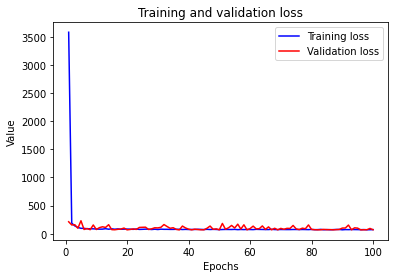

In [19]:
draw_graph(best_history)

ПРОВЕРКА ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВЫХ ДАННЫХ

In [20]:
print("[INFO] RUNNING ON TEST DATA: \n")
mse, mae = best_model.evaluate(x_test, y_test, verbose=1)
print(f"[INFO] Mean squared error is {mse}")
print(f"[INFO] Mean absolute error is {mae}")

[INFO] RUNNING ON TEST DATA: 

27/27 [==============================] - 0s 3ms/step - loss: 105.5938 - mae: 5.4013
[INFO] Mean squared error is 105.59380340576172
[INFO] Mean absolute error is 5.401259422302246


ПРЕДСКАЗАНИЕ НА МОДЕЛИ, СОЗДАННОЙ ***ВРУЧНУЮ***

In [21]:
predicted_y = model.predict(x_test)

 ПРЕДСКАЗАНИЕ НА МОДЕЛИ, СОЗДАННОЙ С ПОМОЩЬЮ ***ТЮНЕРА***

In [22]:
best_predicted_y = best_model.predict(x_test)

ПЕРЕВОДИМ В ВЕКТОРЫ ДЛЯ ПОДСЧЕТА КОРРЕЛЯЦИИ

In [23]:
predicted_y = np.reshape(predicted_y, (predicted_y.shape[0]))
best_predicted_y = np.reshape(best_predicted_y, (best_predicted_y.shape[0]))
y_test = np.reshape(y_test, (y_test.shape[0]))

ПОДСЧЕТ КОРРЕЛЯЦИИ С МОДЕЛЬЮ, СОЗДАННОЙ ***ТЮНЕРОМ***

In [ ]:
best_cc = np.corrcoef(best_predicted_y, y_test)
best_cc = best_cc[0][1]
print(f'Correlation Coefficient: {best_cc}')

ПОДСЧЕТ КОРРЕЛЯЦИИ С МОДЕЛЬЮ, СОЗДАННОЙ ***ВРУЧНУЮ***

In [ ]:
best_cc = np.corrcoef(predicted_y, y_test)
best_cc = best_cc[0][1]
print(f'Correlation Coefficient: {best_cc}')

ГРАФИКИ РАСПРЕДЕЛЕНИЯ ДЕЙСТВИТЕЛЬНЫХ И ПРЕДСКАЗАННЫХ ЗНАЧЕНИЙ Y МОДЕЛИ, СОЗДАННОЙ ***ТЮНЕРОМ***

In [ ]:
sns.distplot(best_predicted_y)
sns.distplot(y)

НАГЛЯДНОЕ СРАВНЕНИЕ ДЕЙСТВИТЕЛЬНЫХ И ПРЕДСКАЗАННЫХ ЗНАЧЕНИЙ МОДЕЛИ, СОЗДАННОЙ ***ТЮНЕРОМ***

In [ ]:
for real, pred in zip(y_test, best_predicted_y):
  print(f"[TRUE] {real} : {pred} [PREDICTED]")

ГРАФИК ЗАВИСИМОСТИ РЕАЛЬНЫХ ЗНАЧЕНИЙ ОТ ПРЕДСКАЗАННЫХ

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


<Figure size 432x288 with 0 Axes>

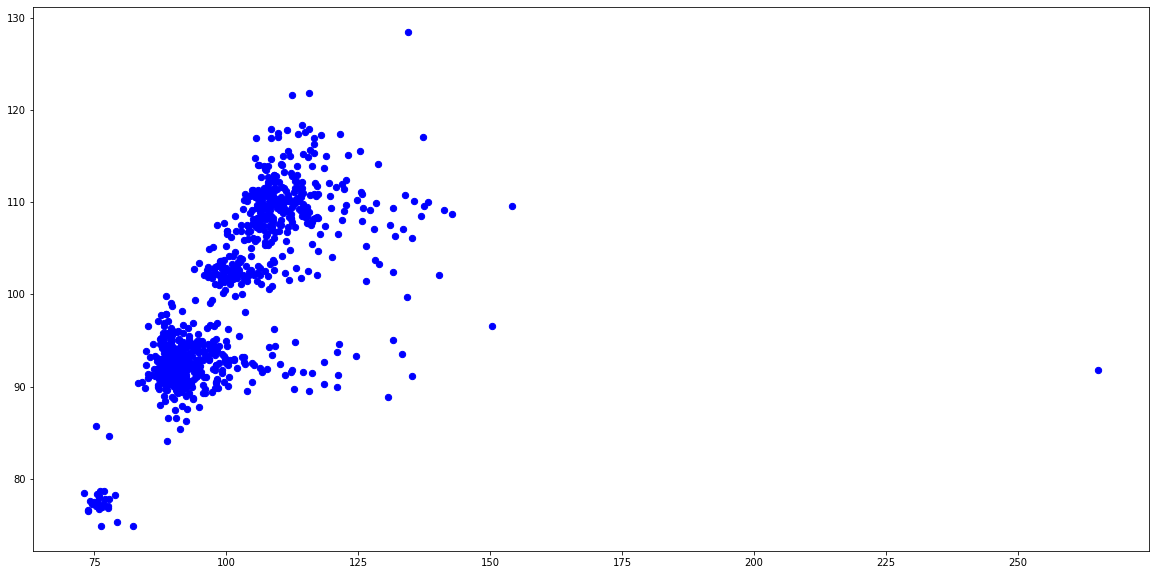

In [37]:
plt.clf()
plt.figure(figsize = (20, 10))
plt.scatter(y_test, best_predicted_y, s = 40, color = 'blue')
plt.axes().get_xaxis().set_visible(True)
plt.axes().get_yaxis().set_visible(True)
plt.show()